<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA 
</center></font>


<center><h2>Actividad 5</h2></center>
<center><h3>Audio</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: Sebastián Andrés Bustos Vásquez</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>
 

## 1. Aplique la transformada rápida de fourier a una señal de audio
<p align="justify">
El archivo de audio debe ser formato .WAV, con menos de 30 segundo de duración.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy.fft import fft, fftfreq

# Leer archivo de audio
sampling_rate, data = wavfile.read('golondrina-chilena.wav')

# Asumo que es sonido stereo, por lo que digo que tiene solo 1 canal
if len(data.shape) > 1:
    data = data[:, 0]

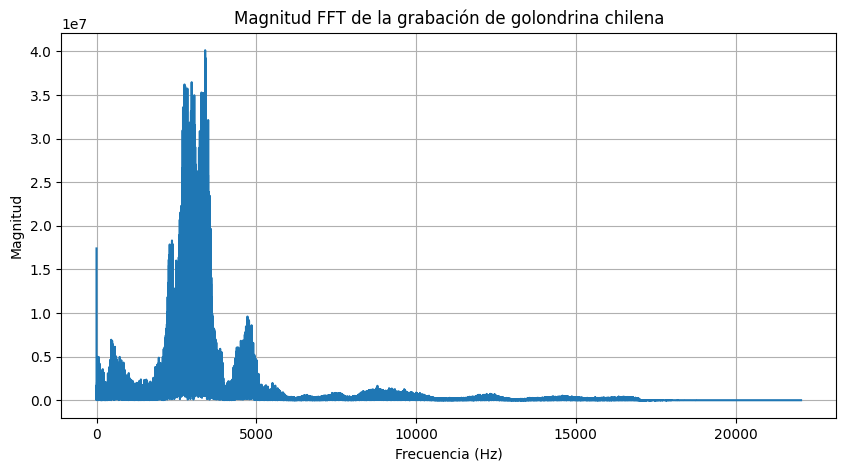

In [2]:
# Aplicar FFT
fft_values = fft(data)
fft_freq = fftfreq(len(fft_values), 1/sampling_rate)

# Tomar solo la mitad de los valores, ya que la FFT es simetrica
fft_values = fft_values[:len(fft_values)//2]
fft_freq = fft_freq[:len(fft_freq)//2]

# Calcular magnitud de la FFT
magnitude = np.abs(fft_values)

plt.figure(figsize=(10, 5))
plt.plot(fft_freq, magnitude)
plt.title('Magnitud FFT de golondrina chilena')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.grid(True)
plt.show()

## 2. Obtén el espectrograma de tu señal de audio

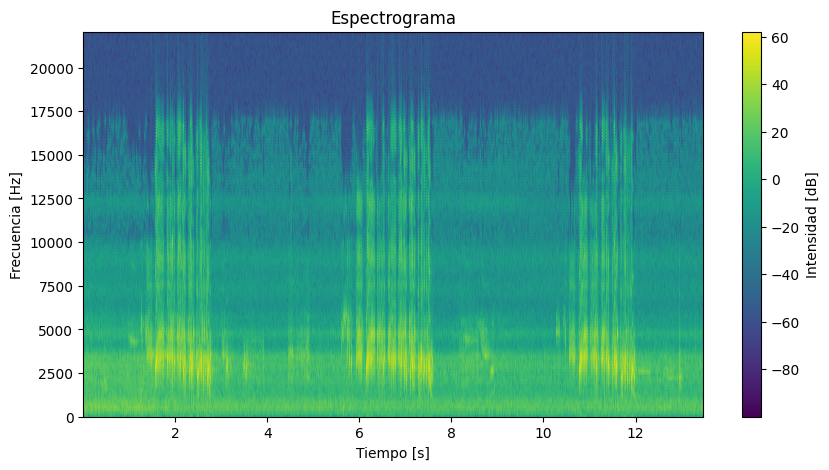

In [3]:
from scipy.signal import spectrogram

# Calcular espectrograma
frequencies, times, spectrogram_data = spectrogram(data, sampling_rate)

# Usar escala logaritmica para amplitud
spectrogram_log = 10 * np.log10(spectrogram_data + 1e-10)

plt.figure(figsize=(10, 5))
plt.pcolormesh(times, frequencies, spectrogram_log, shading='gouraud')
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Tiempo [s]')
plt.title('Espectrograma')
plt.colorbar(label='Intensidad [dB]')
plt.show()

## 3. Slicing
Desarrolla un framento de código que te permita tomar una señal de audio y framentarla en N segmentos o slices. Debe asignar la longitud temporal de cada slice y el programa debe indicar el número de slices que quedan. Considera que al final puede quedar un slice de longitud diferente a todos los demas.

En el slicing debes también incluir un gap o overlap a lado y lado de cada uno de los fragmentos. Este overlap debe ser ajustable del número de muestras que constituyen dicho overlap.

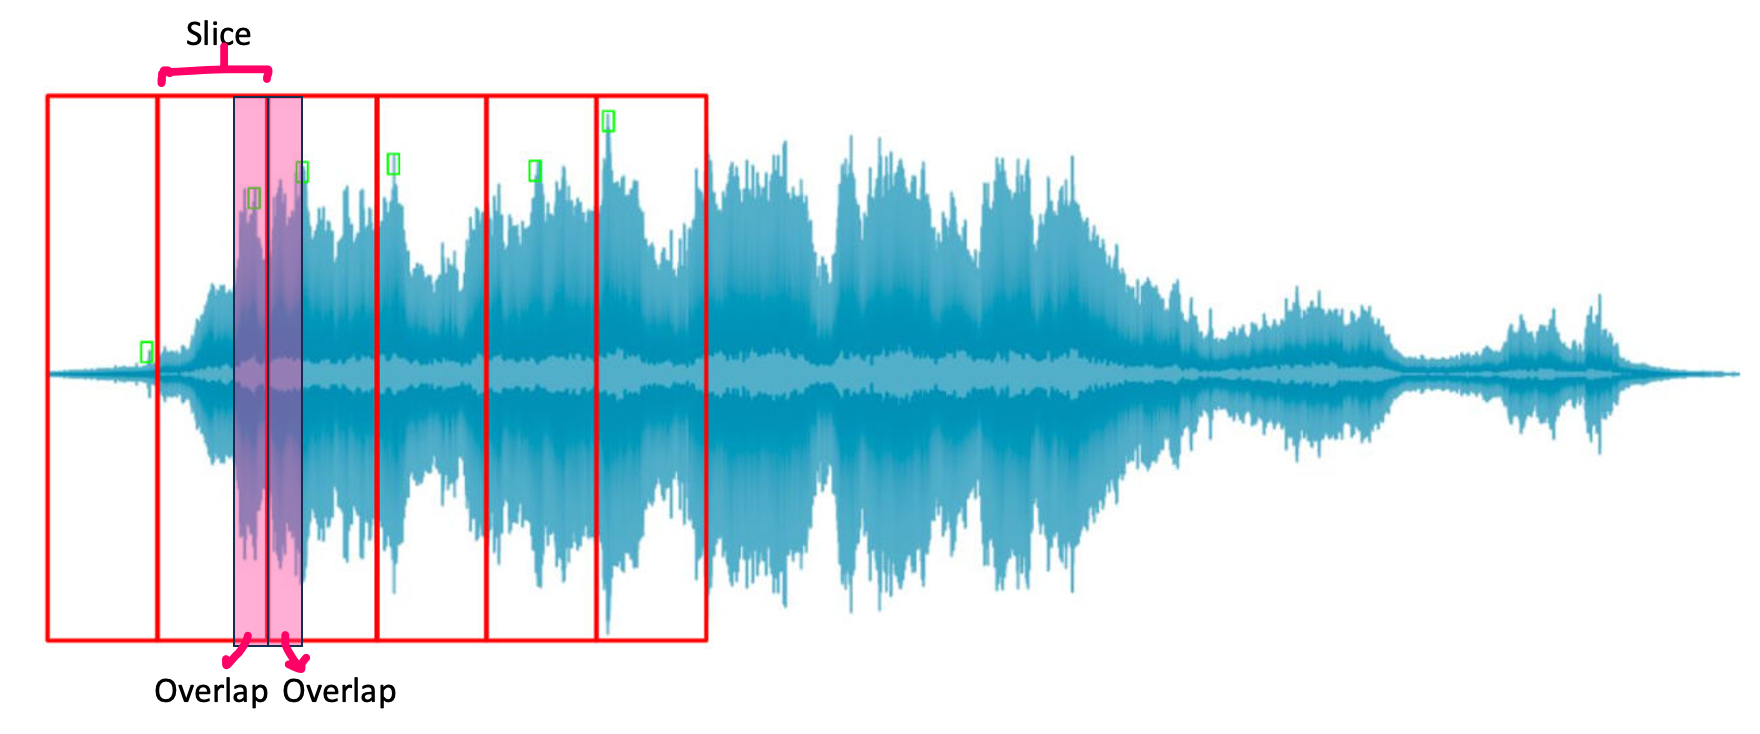

Total de segmentos: 7
Segmento 1: Inicia en la muestra 0, termina en la muestra 88200, Longitud = 88200 muestras
Segmento 2: Inicia en la muestra 87700, termina en la muestra 175900, Longitud = 88200 muestras
Segmento 3: Inicia en la muestra 175400, termina en la muestra 263600, Longitud = 88200 muestras
Segmento 4: Inicia en la muestra 263100, termina en la muestra 351300, Longitud = 88200 muestras
Segmento 5: Inicia en la muestra 350800, termina en la muestra 439000, Longitud = 88200 muestras
Segmento 6: Inicia en la muestra 438500, termina en la muestra 526700, Longitud = 88200 muestras
Segmento 7: Inicia en la muestra 526200, termina en la muestra 594229, Longitud = 68029 muestras


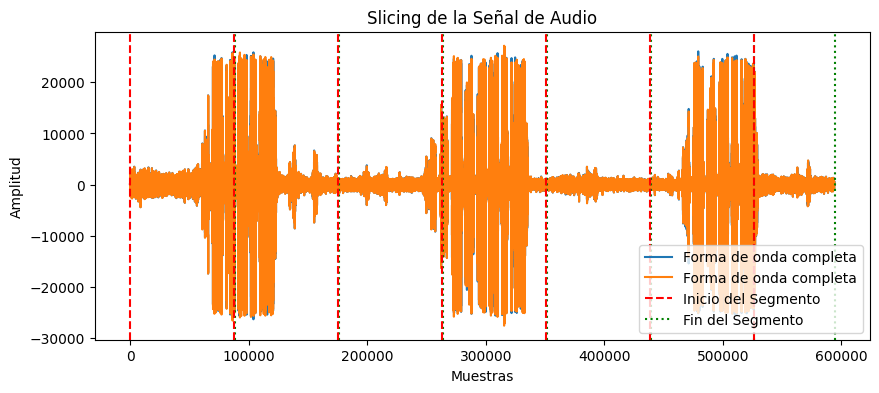

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile

def generate_audio_slices(file_path, segment_duration, overlap_samples):
    # Leer archivo de audio
    sample_rate, data = wavfile.read(file_path)
    
    # Calcular numero de muestras por segmento
    segment_samples = int(segment_duration * sample_rate)
    
    # Calcular inicio de cada segmento
    total_samples = len(data)
    segment_start = 0
    segments = []

    while segment_start + segment_samples <= total_samples:

        segment_end = segment_start + segment_samples # Final de cada segmento incluyendo overlap
        
        # Extraer segmento
        segment = data[segment_start:segment_end]
        segments.append((segment_start, segment_end, segment))
        
        segment_start += segment_samples - overlap_samples # quitar overlap y seguir con el siguiente segmento

    #  Modificar ultimo segmento si no es del tamano completo
    if segment_start < total_samples:
        segments.append((segment_start, total_samples, data[segment_start:total_samples]))

    return segments, sample_rate, data


file_path = 'golondrina-chilena.wav'  # archivo de audio
segment_duration = 2  # Duracion de cada segmento en seg
overlap_samples = 500  # Numero de muestras para el overlap

segments, sample_rate, data = generate_audio_slices(file_path, segment_duration, overlap_samples)

# Informacion de los segmentos
print(f'Total de segmentos: {len(segments)}')
for i, (start, end, segment) in enumerate(segments):
    print(f"Segmento {i+1}: Longitud = {len(segment)} muestras")

# Grafica de la senal de audio y segmentos
plt.figure(figsize=(10, 4))
plt.plot(data, label='Forma de onda completa')
for start, end, segment in segments:
    plt.axvline(x=start, color='r', linestyle='--', label='Inicio del Segmento' if start == segments[0][0] else "")
    plt.axvline(x=end, color='g', linestyle=':', label='Fin del Segmento' if start == segments[0][0] else "")
plt.title('Slicing de la Señal de Audio')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

## 3.1 Slicing usando Pytorch


Total de segmentos: 7
Segmento 1: Longitud = 88200 muestras
Segmento 2: Longitud = 88200 muestras
Segmento 3: Longitud = 88200 muestras
Segmento 4: Longitud = 88200 muestras
Segmento 5: Longitud = 88200 muestras
Segmento 6: Longitud = 88200 muestras
Segmento 7: Longitud = 88200 muestras


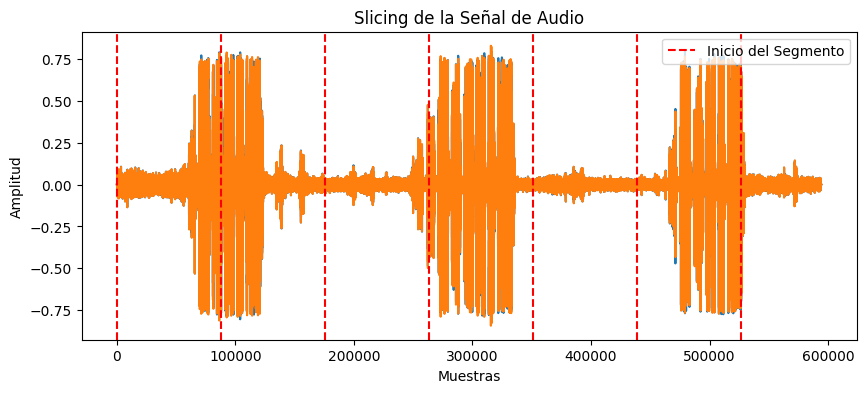

In [8]:
import torch
import torchaudio
import matplotlib.pyplot as plt

def slice_audio_with_pytorch(file_path, segment_duration, overlap_samples, sample_rate):
    # Leer archivo de audio
    waveform, sr = torchaudio.load(file_path)
    
    # Asegurar la tasa de muestreo
    if sr != sample_rate:
        waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=sample_rate)(waveform)
    
    # Calcular numero de muestras por segmento
    segment_samples = int(segment_duration * sample_rate)
    
    # Calcular numero de muestras por cada step
    step = segment_samples - overlap_samples
    segments = []
    
    # Crear segmentos con overlap
    for start in range(0, waveform.shape[1] - segment_samples + 1, step):
        end = start + segment_samples
        segment = waveform[:, start:end]
        segments.append(segment)
    
    # Modificar ultimo segmento si no es del tamano completo
    if end < waveform.shape[1]:
        last_segment = waveform[:, -segment_samples:]
        segments.append(last_segment)
    
    return segments, waveform

file_path = 'golondrina-chilena.wav'  # archivo de audio
segment_duration = 2  # Duracion de cada segmento en seg
overlap_samples = 500  # Numero de muestras para el overlap
sample_rate = 44100  # Debe ser la misma que el archivo de audio

# Slicing del archivo de audio
segments, waveform = slice_audio_with_pytorch(file_path, segment_duration, overlap_samples, sample_rate)

# Informacion de los segmentos
print(f'Total de segmentos: {len(segments)}')
for i, seg in enumerate(segments):
    print(f'Segmento {i+1}: Longitud = {seg.shape[1]} muestras')

# Grafica de la senal de audio y segmentos
plt.figure(figsize=(10, 4))
plt.plot(waveform.t().numpy())
for i, seg in enumerate(segments):
    start = i * (segment_duration * sample_rate - overlap_samples)
    plt.axvline(x=start, color='r', linestyle='--', label='Inicio del Segmento' if i == 0 else "")
plt.title('Slicing de la Señal de Audio')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

In [5]:
# Tuve problemas con el backend
# Intenté con SoX pero no funcionó, con soundfile sí.
# La línea de codigo es para verificar que backend reconoce.

print(torchaudio.list_audio_backends())


['soundfile']


## 4. Filtro Butterworth para una señal de audio.

In [10]:
import numpy as np
import scipy.signal as signal

# Funcion para diseñar un filtro Butterworth paso bajo
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyq

    # Obtener coeficientes del filtro
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    
    # Aplicar el filtro
    y = signal.filtfilt(b, a, data)
    return y

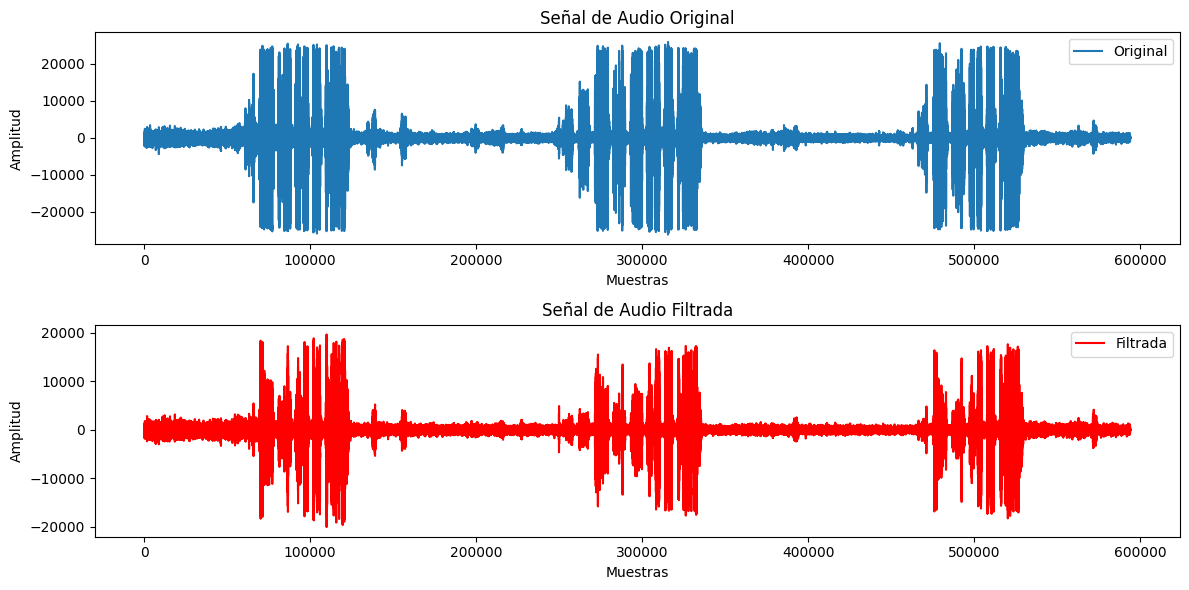

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.io import wavfile

# Funcion para disenar y aplicar filtro Butterworth paso bajo
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)

    y = signal.filtfilt(b, a, data, padtype='odd') # odd en padtype se menciona que funciona mejor para senales cortas
    return y

# Cargar y procesar archivo de audio, filtrar la senal y graficar
def process_and_plot_whole_audio(file_path, cutoff, sample_rate):
    # Cargar el archivo de audio
    sr, data = wavfile.read(file_path)
    if sr != sample_rate:
        raise ValueError("Tasa de muestreo no concuerda con la de archivo de audio.")
    
    # Asumo que es sonido stereo, por lo que digo que tiene solo 1 canal
    if data.ndim > 1:
        data = data.mean(axis=1)

    # Longitud de audio adecuada
    if len(data) < 20:  # Valor arbitrario, se puede ajustar
        raise ValueError("Archivo de audio demasiado corto.")
    
    # Aplicar filtro Butterworth
    filtered_data = butter_lowpass_filter(data, cutoff, sample_rate)

    # Grafica de la senal original y la senal filtrada
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(data, label='Original')
    plt.title('Señal de Audio Original')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(filtered_data, label='Filtrada', color='red')
    plt.title('Señal de Audio Filtrada')
    plt.xlabel('Muestras')
    plt.ylabel('Amplitud')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return filtered_data

file_path = 'golondrina-chilena.wav'  # archivo de audio
sample_rate = 44100  # Debe ser la misma que el archivo de audio
cutoff = 3000  # Frecuencia de corte para el filtro Butterworth

# Procesar archivo de audio con filtro y mostrar graficas
filtered_audio = process_and_plot_whole_audio(file_path, cutoff, sample_rate)



## 4. Referencias
<p align="justify">
    
[Análisis espectral para audio] https://ccrma.stanford.edu/~jos/mdft/mdft-python.html

[Análisis espectral] https://currents.soest.hawaii.edu/ocn_data_analysis/_static/Spectrum.html
